# Project 1

# Used Vehicle Price Prediction


Presented by:

* Andres Felipe Martinez Tunarroza (af.martinez833@uniandes.edu.co)
* Nicolas David Gil Quijano (nd.gil@uniandes.edu.co)
* Jorge Luis Medina Herrada (jl.medina@uniandes.edu.co)


#### MIIA4200 - Mineria de Datos

Departamento de Ingenieria Industrial,
Facultad de Ingenieria

Universidad de los Andes,
2019


____

# Exercise P1.1 (50%)

Develop a machine learning model that predicts the price of the of car using as an input ['Year', 'Mileage', 'State', 'Make', 'Model']

Submit the prediction of the testing set to Kaggle
https://www.kaggle.com/c/miia4200-20191-p1-usedcarpriceprediction

#### Evaluation:
- 25% - Performance of the model in the Kaggle Private Leaderboard
- 25% - Notebook explaining the modeling process

_________

## Introduction

- 1.2 Million listings scraped from TrueCar.com - Price, Mileage, Make, Model dataset from Kaggle: [data](https://www.kaggle.com/jpayne/852k-used-car-listings)
- Each observation represents the price of an used car

_____

## Methodology

![Picture1a](https://github.com/afmartinezt/datamining/raw/master/Project/images/Picture1_vF.png)

_________

# ETL (Extract, *Exploration*-Transformation and Load)

![Picture2a](https://github.com/afmartinezt/datamining/raw/master/Project/images/Picture2_vF.png)

>### Data extract

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')

In [3]:
data.head()

,Price,Year,Mileage,State,Make,Model
0,21490,2014,31909,MD,Nissan,MuranoAWD
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe
2,20925,2016,24633,SC,Hyundai,Santa
3,14500,2012,84026,OK,Jeep,Grand
4,32488,2013,22816,TN,Jeep,Wrangler


In [4]:
data.shape

(500000, 6)

In [5]:
data.Price.describe()

count    500000.000000
mean      21144.186304
std       10753.259704
min        5001.000000
25%       13499.000000
50%       18450.000000
75%       26998.000000
max       79999.000000
Name: Price, dtype: float64

In [6]:
data.plot(kind='scatter', y='Price', x='Year')

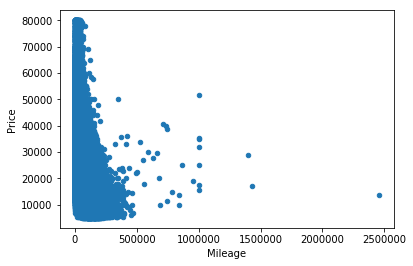

In [7]:
data.plot(kind='scatter', y='Price', x='Mileage')

In [8]:
data.columns

Index(['Price', 'Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

>### Data exploration

In [ ]:
pd.pivot_table(data, index=['Make', 'Model'], aggfunc=[np.mean, np.std])

There are 536 types of Models! Additional to it, some variances are quite high (e.g. Volvo - XC90AWD, Bentley - Continental, Audi - A8)! The prediction will have a high dependence of it Features!

1. #### Exist any relation between variables?

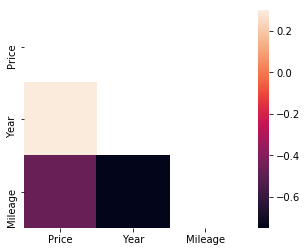

In [9]:
import seaborn as sns

corr = data.drop(['State', 'Make', 'Model'], axis = 1).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            mask=mask, 
            vmax=.3, 
            square=True)

According the graphic above:
- Year and Price are the only with a positive relation. Between a car is newer (a greater year), the price will increase!
- If the Mileage of a car increase, the Price will decreace! 
- The greatest (in this, negative correlation) correlation is between Mileage and Year ~ -0.7

2. #### How the price is distributed?

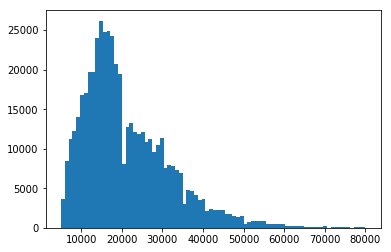

In [11]:
import matplotlib.pyplot as plt

plt.hist(data['Price'], bins=80)
plt.show()

Seems that follows a logarithm patron...

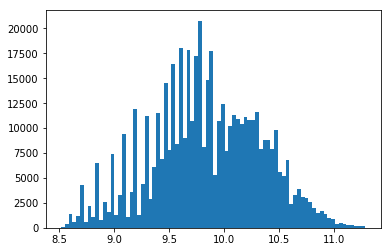

In [12]:
plt.hist(np.log(data['Price']), bins=80)
plt.show()

Applying a logarithm transformation (click [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log.html) for more details), we get a *normal* distribution for the price!

3. #### How the features are distributed?

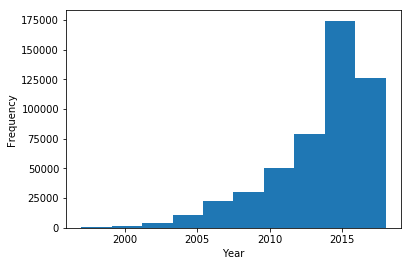

In [13]:
plt.hist(data['Year'])
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

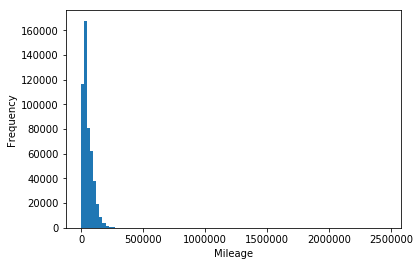

In [14]:
plt.hist(data['Mileage'], bins=100)
plt.xlabel('Mileage')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.hist(data['State'])
plt.xlabel('State')
plt.ylabel('Frequency')
plt.show()

4. #### Missing values?

In [15]:
data.isnull().sum()

Price      0
Year       0
Mileage    0
State      0
Make       0
Model      0
dtype: int64

There is no missing values!

5. #### Outliers?

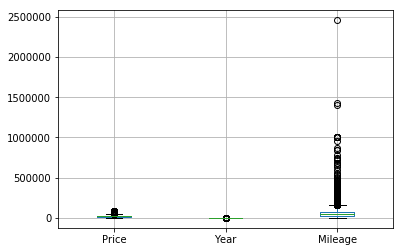

In [16]:
data.boxplot()

Seems we should focus on **Mileage**

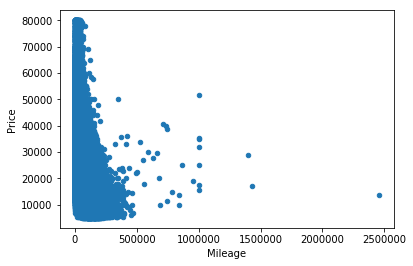

In [17]:
data.plot(kind='scatter', y='Price', x='Mileage')

In [18]:
data.loc[data.Mileage == data['Mileage'].max()]

,Price,Year,Mileage,State,Make,Model
96163,13686,2013,2457832,GA,Chevrolet,Silverado


Because design considerations, will ignore those register that have a lower mileage of 30000 since does not show up any pattern

In [19]:
data = data[data.Mileage <= 300000]
data.shape

(499798, 6)

we are ignoring just 202 registers... the 0.0404% of the whole training dataset

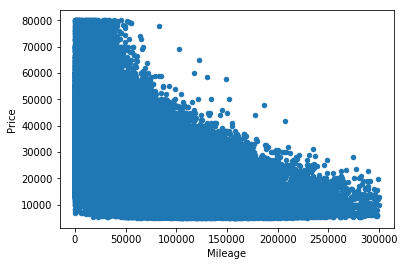

In [20]:
data.plot(kind='scatter', y='Price', x='Mileage')

>### Data transformation

1. #### Target (Independent variable)

![Picture3a](https://github.com/afmartinezt/datamining/raw/master/Project/images/Picture3_vF.png)

Because the findings in the exploration section, we consider to apply the logarithm transformation to the price. 

In [21]:
price_log = np.log(data['Price'])

    # Obtaining the parameters for de-transformation if needed.
price_log_mean = price_log.mean()
price_log_std = price_log.std()

Since the purpose of this analysis is to make a prediction over the price, will be normalize **price**.

In [22]:
from sklearn import preprocessing

y = preprocessing.scale(price_log)

If we consider to transform the target (in training) with a logarithm transformation and normalization, we needs to *de-transform* it!

In [23]:
def y_detransformation(input_, mean, std):
    return np.exp((input_ * std) + mean)

2. #### Features (Dependent variables)

![Picture4a](https://github.com/afmartinezt/datamining/raw/master/Project/images/Picture4_vF.png)

What kind of features we have?

In [24]:
X = data.drop(['Price'], axis = 1)
X.sample(2)

,Year,Mileage,State,Make,Model
288392,2016,31207,AK,Kia,SportageLX
412363,2016,40818,FL,Toyota,CamrySE


In [25]:
X.dtypes

Year        int64
Mileage     int64
State      object
Make       object
Model      object
dtype: object

Given the restrictions for scikit-learn - [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), the type "object" is not recognized!

Then, we needs to transform it to a type that scikit-learn understand.

We made 2 case of studies:

#### Using LabelEncode:

1. Dismiss the fact of ordinality, seeking computational performance. (See more: [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html))
2. Normalize the features (*int*) for the RandomForestRegressor since the target (price) was already normalized

#### BinaryEncoder

For this, we will use a BinaryEncoder (click [here](http://contrib.scikit-learn.org/categorical-encoding/) for more details) to specify the correct transformation of the input.

1. Won't impact if the variables have some order or not.
2. Implies a high computational impact

In [26]:
#def X_transformation(X):
#    
#    aux = X
#    X = X.apply(preprocessing.LabelEncoder().fit_transform)
#    
#    X['Mileage'] = preprocessing.scale(aux['Mileage'])
#    X['Year'] = preprocessing.scale(aux['Year'])
#    X['State'] = X['State'].astype('category')
#    X['Make'] = X['Make'].astype('category')
#    X['Model'] = X['Model'].astype('category')
#    
#    return X

In [29]:
import category_encoders as ce

encoder = ce.BinaryEncoder()
encoder.fit(data.drop(['Price'], axis = 1), axis=1)
    
def X_transformation(X):
    X = encoder.transform(X)
    X['Mileage'] = preprocessing.scale(X['Mileage'])
    X['Year'] = preprocessing.scale(X['Year'])
    
    return X

In [30]:
X = X_transformation(X)
X.head(3)

C:\Users\AMartinez147\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\AMartinez147\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


,State_0,State_1,State_2,State_3,State_4,State_5,State_6,Make_0,Make_1,Make_2,...,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10,Year,Mileage
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0.243462,-0.576071
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0.851927,-0.730419
2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,1,0.851927,-0.758145


>### Data load

Will have 3 main dataset across the notebook:

- Sub-dataset to obtain the hyperparameters of the model.
- Training dataset (500,000 originally) for main model training 
- Test dataset (250,000) for Kaggle competition (*will explain later on the notebook on the section 'Prediction'*)

In [31]:
# Sub-dataset to obtain the hyperparameters of the model.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6, train_size = 0.7, test_size = 0.3)

X_train.head(2)

,State_0,State_1,State_2,State_3,State_4,State_5,State_6,Make_0,Make_1,Make_2,...,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10,Year,Mileage
274173,0,0,0,1,1,1,0,0,0,0,...,1,0,0,1,0,1,0,0,1.156159,-1.021847
166824,0,0,1,1,1,0,1,0,0,0,...,1,0,1,0,1,1,1,0,-0.669236,1.255354


In [32]:
# Training dataset (500,000 originally) for main model training

X.head(2)

,State_0,State_1,State_2,State_3,State_4,State_5,State_6,Make_0,Make_1,Make_2,...,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10,Year,Mileage
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0.243462,-0.576071
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0.851927,-0.730419


# Model 

![Picture5a](https://github.com/afmartinezt/datamining/raw/master/Project/images/Picture5.png)

>### Hyperparameters search

* #### Base

In [33]:
from sklearn.ensemble import RandomForestRegressor

tree = RandomForestRegressor(random_state=6, n_jobs=-1)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

In [34]:
from sklearn import metrics

base = metrics.mean_absolute_error( y_test , y_pred )
base

0.23262714602312684

* #### *max_depth* parameter

In [35]:
max_depth_p = [base]

for Max_depth in range(1, 50, 1):
    tree = RandomForestRegressor(max_depth = Max_depth,
                                  random_state=6, n_jobs=-1)
    
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    
    max_depth_p.append( metrics.mean_absolute_error( y_test , y_pred )  )

*visual aid*

Text(0,0.5,'mean squared error')

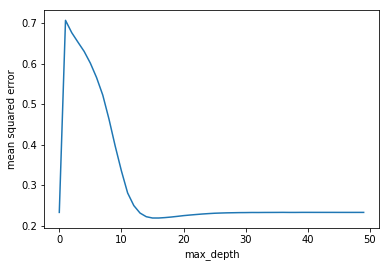

In [36]:
max_depth_p_df = pd.DataFrame(max_depth_p)
max_depth_p_df.rename(columns={0 : 'max_depth'}, inplace=True)

plt.plot(max_depth_p_df)
plt.xlabel('max_depth')
plt.ylabel('mean squared error')

Value for the best root mean squared error considerin the parameter *max_depth*

In [37]:
if len(max_depth_p_df.loc[max_depth_p_df.max_depth == max_depth_p_df["max_depth"].min()]) != 1:
    max_depth_choose = max_depth_p_df.loc[max_depth_p_df.max_depth == max_depth_p_df["max_depth"].min()][0]
else:
    if int(max_depth_p_df.loc[max_depth_p_df.max_depth == max_depth_p_df["max_depth"].min()].index.values) != 0:
        max_depth_choose = int(max_depth_p_df.loc[max_depth_p_df.max_depth == max_depth_p_df["max_depth"].min()].index.values)
    else:
        max_depth_choose = 'auto'
        
max_depth_p_df.loc[max_depth_p_df.max_depth == max_depth_p_df["max_depth"].min()]

,max_depth
16,0.218774


* #### *max_features* parameter

In [38]:
feature_cols = X_train.columns[X_train.columns.str.startswith('C') == False]
max_features_p = [base]

feature_range = range(1, len(feature_cols) + 1)

for Max_features in feature_range:
    tree = RandomForestRegressor(max_depth = max_depth_choose,
                                 max_features = Max_features,
                                 random_state=6, n_jobs=-1)
    
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    
    max_features_p.append( metrics.mean_absolute_error( y_test , y_pred )  )

*visual aid*

Text(0,0.5,'mean squared error')

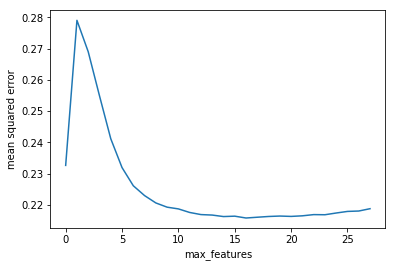

In [39]:
max_features_p_df = pd.DataFrame(max_features_p)
max_features_p_df.rename(columns = {0 : 'max_features'}, inplace=True)

plt.plot(max_features_p_df)
plt.xlabel('max_features')
plt.ylabel('mean squared error')

Value for the best root mean squared error considerin the parameter *max_features*

In [40]:
if len(max_features_p_df.loc[max_features_p_df.max_features == max_features_p_df["max_features"].min()]) != 1:
    max_features_choose = max_features_p_df.loc[max_features_p_df.max_features == max_features_p_df["max_features"].min()][0]
else:
    if int(max_features_p_df.loc[max_features_p_df.max_features == max_features_p_df["max_features"].min()].index.values) != 0:
        max_features_choose = int(max_features_p_df.loc[max_features_p_df.max_features == max_features_p_df["max_features"].min()].index.values)
    else:
        max_features_choose = 'auto'

max_features_p_df.loc[max_features_p_df.max_features == max_features_p_df["max_features"].min()]

,max_features
16,0.215796


* #### *n_estimators* parameter

In [ ]:
n_estimators_p = [base]

for N_estimator in range(1, 1000, 10):
    tree = RandomForestRegressor(max_depth = max_depth_choose,
                                 max_features = max_features_choose,
                                 n_estimators = N_estimator,
                                 random_state=6, n_jobs=-1)
    
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    
    n_estimators_p.append( metrics.mean_absolute_error( y_test , y_pred )  )

*visual aid*

In [ ]:
n_estimators_p_df = pd.DataFrame(n_estimators_p)
n_estimators_p_df.rename(columns = {0 : 'n_estimators'}, inplace=True)

plt.plot(n_estimators_p_df)
plt.xlabel('n_estimators')
plt.ylabel('mean_squared_error')

Value for the best root mean squared error considerin the parameter *max_features*

In [ ]:
if len(n_estimators_p_df.loc[n_estimators_p_df.n_estimators == n_estimators_p_df["n_estimators"].min()]) != 1:
    n_estimators_choose = 'auto'
else:
    if int(n_estimators_p_df.loc[n_estimators_p_df.n_estimators == n_estimators_p_df["n_estimators"].min()].index.values) != 0:
        n_estimators_choose = 10 * int(n_estimators_p_df.loc[n_estimators_p_df.n_estimators == n_estimators_p_df["n_estimators"].min()].index.values)
    else:
        n_estimators_choose = 'auto'

n_estimators_p_df.loc[n_estimators_p_df.n_estimators == n_estimators_p_df["n_estimators"].min()]

>### Model definition

In [ ]:
tree = RandomForestRegressor(max_depth = max_depth_choose,
                             max_features = max_features_choose,
                             n_estimators = n_estimators_choose,
                             oob_score = True,
                             random_state=6, n_jobs=-1)

In [ ]:
tree.fit(X, y)

Other models tried:
* RandomForestClassifier : Computational performance (See the difference [here](https://www.quora.com/What-is-the-difference-between-scikit-learns-random-forest-classifier-and-random-forest-regressor))
* SMV : Computational performance
* KNeighborsClassifier : Poor prediction with default values - Computational performance fitting the parameter n_neighbors

* ## Prediction

![Picture6a](https://github.com/afmartinezt/datamining/raw/master/Project/images/Picture6_vF.png)

In [ ]:
data_test = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTest_carListings.zip', index_col=0)

In [ ]:
data_test.head()

In [ ]:
data_test.shape

Exist missing values?

In [ ]:
data_test.isnull().sum()

No! There is no missing value on the *data_test* set

In [ ]:
data_test = X_transformation(data_test)
data_test.head(3)

Exist a random feature on *RandomForestRegressor* let's run, at least, 20 different random to discard any influence of the *random_state* choose over the prediction!

In [ ]:
Aux = []

for ran in range(1, 10, 1):
    tree = RandomForestRegressor(max_depth = max_depth_choose,
                                 max_features = max_features_choose,
                                 n_estimators = n_estimators_choose,
                                 oob_score = True,
                                 random_state = ran, 
                                 n_jobs=-1)
    
    tree.fit(X, y)
    Aux.append( tree.predict(data_test) )

In [ ]:
y_pred = pd.DataFrame(Aux).T.median(axis=1)
y_pred = y_detransformation(y_pred, price_log_mean, price_log_std)
y_pred = pd.DataFrame(y_pred)
y_pred.rename(columns={0 : "Price"}, inplace = True)

### Submission

In [ ]:
y_pred.to_csv('test_submission.csv', index_label='ID')

In [ ]:
y_pred.head()

______

# Exercise P1.2 (50%)

Create an API of the model.

#### Evaluation:
- 40% - API hosted on a cloud service
- 10% - Show screenshots of the model doing the predictions on the local machine

_____

## Methodology

![NoName](https://github.com/afmartinezt/datamining/raw/master/Project/images/Picture8-Copy.PNG)

> #### Data Preparation

You may notice that this was used before; was used in order to prevent the impact by ordanization of the features (a problem identified above but dismissed in order to improve the computational performance in 1 case of study).

In [ ]:
import category_encoders as ce

encoder = ce.BinaryEncoder()
encoder.fit(data.drop(['Price'], axis = 1), axis=1)

The variable *encoder*, now will have the transformation required to transform from strings to dummies the categorical features of the model. This dummies will follow a binary codification

> #### Model for the API

In order to improve the performance of the API, we are specifying a new RandomForestRegressor without the fitted hyperparameters.

In [ ]:
X_encoded = encoder.transform(data.drop(['Price'], axis = 1))

In [ ]:
from sklearn.ensemble import RandomForestRegressor

tree = RandomForestRegressor()
tree.fit(X_encoded, y)

> #### Export

With the Encoder (to transform the features to the model language) and the Model (to make the Price prediction), both are export to **.pkl** in order to create properly the API.

In [ ]:
from sklearn.externals import joblib

#joblib.dump(tree, 'model_deployment/price_pred.pkl', compress=3)
#joblib.dump(encoder, 'model_deployment/encode.pkl', compress=3)

### API 

> #### API creation

In [ ]:
from flask import Flask
from flask_restplus import Api, Resource, fields
from sklearn.externals import joblib

In [ ]:
app = Flask(__name__)

api = Api(
    app, 
    version='1.0', 
    title='Price prediction - API',
    description='Developed by Andres Martinez, Nicolas Gil and Jorge Medina')

ns = api.namespace('predict', 
     description='Price')
   
parser = api.parser()

parser.add_argument(
    'Data Year',
    type=int, 
    required=True, 
    help='Year', 
    location='args')
parser.add_argument(
    'Data Mileage',
    type=int, 
    required=True, 
    help='Mileage', 
    location='args')

parser.add_argument(
    'Data State',
    type=str, 
    required=True, 
    help='State', 
    location='args')


parser.add_argument(
    'Data Make',
    type=str, 
    required=True, 
    help='Make', 
    location='args')

parser.add_argument(
    'Data Model',
    type=str, 
    required=True, 
    help='Model', 
    location='args')

resource_fields = api.model('Resource', {
    'result': fields.Integer,
})

In [ ]:
from model_deployment.m09_model_deployment import predict_price

In [ ]:
@ns.route('/')
class PriceApi(Resource):

    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    def get(self):
        args = parser.parse_args()
        
        return {
         "result": predict_price(args['Data Year'],args['Data Mileage'],args['Data State'],
                                                                             args['Data Make'],args['Data Model'])
        }, 200

> #### API launch

In [ ]:
app.run(debug=True, use_reloader=False, host='0.0.0.0', port=5000)

Check it running locally: http://localhost:5000/

> #### API cloud

In order to access to the API hosted in a cloud service (Amazon Web Services [AWS](https://aws.amazon.com/)), just go to the following IP Address http://13.59.32.163:8088/ and test it!

Let's see here a brief example of one request made:

http://13.59.32.163:8088/predict/?Data%20Year=2010&Data%20Mileage=12345&Data%20State=TX&Data%20Make=Audi&Data%20Model=A8

> #### Evidence


![evi1](https://github.com/afmartinezt/datamining/raw/master/Project/images/2019-03-1112_49_15-Window.png)

![evi2](https://github.com/afmartinezt/datamining/raw/master/Project/images/2019-03-1112_50_16-Window.png)

![evi3](https://github.com/afmartinezt/datamining/raw/master/Project/images/2019-03-1112_50_44-Window.png)

![evi4](https://github.com/afmartinezt/datamining/raw/master/Project/images/2019-03-1112_51_02-Window.png)